# TAMIDS Point

This lab contains a P2PNet model built from strach and a loss function which is a conbination of point based on distance loss and cross entropy loss. Possible applications for such a model can be c. difficile spore detection or pedestrian detection. Both datasets are provided by TAMIDS with its collaborators.

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, DistributedSampler,Dataset
import numpy as np
from matplotlib import pyplot as plt
import os
from tensorboardX import SummaryWriter
import time
import cv2
import pandas as pd
import random
import torch
from PIL import Image
import glob
import scipy.io as io

# Make folder to save model and tensorboard

In [ ]:
date_folder='20240109_scratch/'

output_dir=os.path.join(date_folder,'out/')

tensorboard_dir=os.path.join(date_folder,'tensorboard/')
checkpoints_dir=os.path.join(date_folder,'ckpts/')

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
if not os.path.exists(tensorboard_dir):
    os.makedirs(tensorboard_dir)
if not os.path.exists(checkpoints_dir):
    os.makedirs(checkpoints_dir)

In [ ]:
date_folder

In [ ]:
tensorboard_dir

# Build Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Backbone_VGG(nn.Module):
    def __init__(self):
        super(Backbone_VGG, self).__init__()
        self.body1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        
        self.body2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        
        self.body3 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        
        self.body4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        out1 = self.body1(x)
        out2 = self.body2(out1)
        out3 = self.body3(out2)
        out4 = self.body4(out3)
        
        return out1, out2, out3, out4


class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.conv1 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.conv2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.conv3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.act3 = nn.ReLU()
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.act4 = nn.ReLU()
        self.output = nn.Conv2d(256, 8, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        out = self.conv1(x)
        out = self.act1(out)
        out = self.conv2(out)
        out = self.act2(out)
        out = self.conv3(out)
        out = self.act3(out)
        out = self.conv4(out)
        out = self.act4(out)
        out = self.output(out)
        
        out = out.permute(0, 2, 3, 1)

        return out.contiguous().view(out.shape[0], -1, 2)


class ClassificationModel(nn.Module):
    def __init__(self, num_features_in=256, num_anchor_points=4, num_classes=2, prior=0.01, feature_size=256):
        super(ClassificationModel, self).__init__()

        self.num_classes = num_classes
        self.num_anchor_points = num_anchor_points

        self.conv1 = nn.Conv2d(num_features_in, feature_size, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()

        self.conv2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()

        self.conv3 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act3 = nn.ReLU()

        self.conv4 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act4 = nn.ReLU()

        self.output = nn.Conv2d(feature_size, num_anchor_points * num_classes, kernel_size=3, padding=1)
        self.output_act = nn.Sigmoid()
        
    # sub-branch forward
    def forward(self, x):
        out = self.conv1(x)
        out = self.act1(out)

        out = self.conv2(out)
        out = self.act2(out)

        out = self.output(out)

        out1 = out.permute(0, 2, 3, 1)

        batch_size, width, height, _ = out1.shape

        out2 = out1.view(batch_size, width, height, self.num_anchor_points, self.num_classes)

        return out2.contiguous().view(x.shape[0], -1, self.num_classes)

class AnchorPoints(nn.Module):
    def __init__(self, pyramid_levels=None, strides=None, row=3, line=3):
        super(AnchorPoints, self).__init__()

        if pyramid_levels is None:
            self.pyramid_levels = [3, 4, 5, 6, 7]
        else:
            self.pyramid_levels = pyramid_levels

        if strides is None:
            self.strides = [2 ** x for x in self.pyramid_levels]

        self.row = row
        self.line = line

    def forward(self, image):
        image_shape = image.shape[2:]
        image_shape = np.array(image_shape)
        image_shapes = [(image_shape + 2 ** x - 1) // (2 ** x) for x in self.pyramid_levels]

        all_anchor_points = np.zeros((0, 2)).astype(np.float32)
        # get reference points for each level
        for idx, p in enumerate(self.pyramid_levels):
            anchor_points = generate_anchor_points(2**p, row=self.row, line=self.line)
            shifted_anchor_points = shift(image_shapes[idx], self.strides[idx], anchor_points)
            all_anchor_points = np.append(all_anchor_points, shifted_anchor_points, axis=0)

        all_anchor_points = np.expand_dims(all_anchor_points, axis=0)
        # send reference points to device
        if torch.cuda.is_available():
            return torch.from_numpy(all_anchor_points.astype(np.float32)).cuda()
        else:
            return torch.from_numpy(all_anchor_points.astype(np.float32))
def generate_anchor_points(stride=16, row=3, line=3):
    row_step = stride / row
    line_step = stride / line

    shift_x = (np.arange(1, line + 1) - 0.5) * line_step - stride / 2
    shift_y = (np.arange(1, row + 1) - 0.5) * row_step - stride / 2

    shift_x, shift_y = np.meshgrid(shift_x, shift_y)

    anchor_points = np.vstack((
        shift_x.ravel(), shift_y.ravel()
    )).transpose()

    return anchor_points

def shift(shape, stride, anchor_points):
    shift_x = (np.arange(0, shape[1]) + 0.5) * stride
    shift_y = (np.arange(0, shape[0]) + 0.5) * stride

    shift_x, shift_y = np.meshgrid(shift_x, shift_y)

    shifts = np.vstack((
        shift_x.ravel(), shift_y.ravel()
    )).transpose()

    A = anchor_points.shape[0]
    K = shifts.shape[0]
    all_anchor_points = (anchor_points.reshape((1, A, 2)) + shifts.reshape((1, K, 2)).transpose((1, 0, 2)))
    all_anchor_points = all_anchor_points.reshape((K * A, 2))

    return all_anchor_points


class Decoder(nn.Module):
    def __init__(self, C3_size, C4_size, C5_size, feature_size=256):
        super(Decoder, self).__init__()

        # upsample C5 to get P5 from the FPN paper
        self.P5_1 = nn.Conv2d(C5_size, feature_size, kernel_size=1, stride=1, padding=0)
        self.P5_upsampled = nn.Upsample(scale_factor=2, mode='nearest')
        self.P5_2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, stride=1, padding=1)

        # add P5 elementwise to C4
        self.P4_1 = nn.Conv2d(C4_size, feature_size, kernel_size=1, stride=1, padding=0)
        self.P4_upsampled = nn.Upsample(scale_factor=2, mode='nearest')
        self.P4_2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, stride=1, padding=1)

        # add P4 elementwise to C3
        self.P3_1 = nn.Conv2d(C3_size, feature_size, kernel_size=1, stride=1, padding=0)
        self.P3_upsampled = nn.Upsample(scale_factor=2, mode='nearest')
        self.P3_2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, stride=1, padding=1)


    def forward(self, inputs):
        C3, C4, C5 = inputs

        P5_x = self.P5_1(C5)
        P5_upsampled_x = self.P5_upsampled(P5_x)
        P5_x = self.P5_2(P5_x)

        P4_x = self.P4_1(C4)
        P4_x = P5_upsampled_x + P4_x
        P4_upsampled_x = self.P4_upsampled(P4_x)
        P4_x = self.P4_2(P4_x)

        P3_x = self.P3_1(C3)
        P3_x = P3_x + P4_upsampled_x
        P3_x = self.P3_2(P3_x)

        return [P3_x, P4_x, P5_x]


class P2PNet(nn.Module):
    def __init__(self):
        super(P2PNet, self).__init__()
        self.backbone = Backbone_VGG()
        self.regression = RegressionModel()
        self.classification = ClassificationModel()
        self.anchor_points = AnchorPoints(pyramid_levels=[3,], row=2, line=2)
        self.fpn =  Decoder(256, 512, 512)

    def forward(self, x):
        features = self.backbone(x)
        features_fpn = self.fpn([features[1], features[2], features[3]])
        
        batch_size = features[0].shape[0]
        regression_out = self.regression(features_fpn[1]) * 100 # 8x
        classification_out = self.classification(features_fpn[1])
        anchor_points_out = self.anchor_points(x).repeat(batch_size, 1, 1)
        
        output_coord = regression_out.to(device) + anchor_points_out.to(device)
        
        output_class = classification_out
        out = {'pred_logits': output_class, 'pred_points': output_coord}
       
        return out


# Load pretrained model

In [ ]:
# Create an instance of the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device='cpu'
model = P2PNet()
# PATH='SHTechA1.pth'
# # PATH=checkpoints_dir+'/latest.pth'

# checkpoint = torch.load(PATH, map_location=device)
# model.load_state_dict(checkpoint['model'])
model.to(device)
# model.eval();

# Calculating the std and mean of the dataset. 

In [ ]:
image_folder_path = "/scratch/user/piyalong/CDI/20230206_BioDataset/"
image_paths = [os.path.join(image_folder_path, img) for img in os.listdir(image_folder_path) if img.endswith(('.jpg', '.jpeg', '.png', '.gif'))]
label_paths = [x[:-4]+'.txt' for x in image_paths]

This code is to remove the images without annotation. It is a temporary solve for now. Eventually, the loss funtion will take care of that. 

In [ ]:
# for i in label_paths:
#     with open(i, 'r') as file:
#         # Read the entire content
#         coordinates_str = file.read()
#     file.close()
#     if len(coordinates_str)==0:
#         print(i)
#         os.remove(i)
#         os.remove(i[:-4]+'.jpg')

#         # coordinate_pairs = coordinates_str.strip().split('\n')
    
#         # pair_list = [pair.split() for pair in coordinate_pairs]
#         # points = [[int(x),int(y)] for x,y in pair_list]

In [ ]:
import os
import numpy as np
from PIL import Image

# Specify the path to your image folder
image_folder_path = "/scratch/user/piyalong/CDI/data/"

# Get a list of all image file paths in the folder
image_paths = [os.path.join(image_folder_path, img) for img in os.listdir(image_folder_path) if img.endswith(('.jpg', '.jpeg', '.png', '.gif'))]

# Calculate mean and std
def compute_image_mean_std(image_paths):
    means, stds = [], []

    for path in image_paths:
        img = Image.open(path)
        img = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
        means.append(np.mean(img, axis=(0, 1)))
        stds.append(np.std(img, axis=(0, 1)))

    mean = np.mean(means, axis=0)
    std = np.mean(stds, axis=0)

    return mean, std

# Call the function
dataset_mean, dataset_std = compute_image_mean_std(image_paths)

print("Dataset Mean:", dataset_mean)
print("Dataset Std:", dataset_std)

# Custom Dataset

The resize image function here is to deal with some of the rounding error in the model. A random image input will raise this dimension mismatch error. This is not necessary if the model is well designed. 

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize(mean=dataset_mean,
                         std=dataset_std)])

def resize_image_with_annotations(image, target, new_size):
    # Open the image
    h, w = image.shape[:2]
    points=target['point']
    # Calculate the scaling factors for x and y dimensions
    scale_x = new_size[0] / w
    scale_y = new_size[1] / h

    # Resize the image
    resized_image = cv2.resize(image,new_size)

    # Resize and adjust the point annotations
    resized_points = [(int(x * scale_x), int(y * scale_y)) for x, y in points]
    target['point']= torch.Tensor(resized_points)
    return resized_image, target

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, root_dir):
        self.transform = transform
        self.images = []
        self.labels = []
        
        image_folder_path = root_dir 
        image_paths = [os.path.join(image_folder_path, img) for img in os.listdir(image_folder_path) if img.endswith(('.jpg', '.jpeg', '.png', '.gif'))]
        label_paths = [x[:-4]+'.txt' for x in image_paths]
        
        for img,label in zip(image_paths,label_paths):
            
            # image_name = img
            # img_path = os.path.join(root_dir,'Video Frames - Interpolated Annotations' , image_name)
            self.images.append(img)
            self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        assert index <= len(self), 'index range error'
        img_path=self.images[index]
        img_cv2 = cv2.imread(img_path)
        img_array = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)
        # load ground truth points

        label_path = self.labels[index]
        with open(label_path, 'r') as file:
            # Read the entire content
            coordinates_str = file.read()
            coordinate_pairs = coordinates_str.strip().split('\n')
        
            pair_list = [pair.split() for pair in coordinate_pairs]
            # print(coordinates_str,len(coordinates_str))
            # if len(coordinates_str)==0:points=[]
            # else:
            points = [[int(float(x)),int(float(y))] for x,y in pair_list]
    
        target={}
        target['point'] = torch.Tensor(points)
        # image_id = img_path.split('/')[-1]
        # target['image_ids']=torch.Tensor(image_id)
        target['labels'] = torch.ones(len(points)).long()
        
        new_size=( 1408,1024)
        img, target=resize_image_with_annotations(img_array,target,new_size)
        img = self.transform(img)
        return img, target


In [ ]:
def collate_fn_ped(batch):
    data = [item[0] for item in batch]
    target = [item[1] for item in batch]
    data=torch.stack(data)
    # target = torch.LongTensor(target)
    return data, target


In [ ]:
test_dir="/scratch/user/piyalong/CDI/data/"
train_dir="/scratch/user/piyalong/CDI/20230206_BioDataset/"

In [ ]:
train_set = CustomDataset(train_dir)
val_set = CustomDataset(test_dir)

In [ ]:
data_loader_train = DataLoader(train_set, batch_size=2, collate_fn=collate_fn_ped,shuffle=True)
data_loader_test = DataLoader(val_set, batch_size=2, collate_fn=collate_fn_ped,shuffle=True)

In [ ]:
len(data_loader_train)

In [ ]:
len(data_loader_test)

# Show some annotation examples

The annotation points are marked with white stars.

In [ ]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

unorm = UnNormalize(dataset_mean, dataset_std)

for batch_images, batch_labels in data_loader_test:
    for image,target in zip(batch_images, batch_labels):
        image=unorm(image)
        landmarks=target['point']
        image_numpy=image.cpu().numpy().copy()
        image_numpy = np.transpose(image_numpy, (1, 2, 0))
        if len(landmarks)>0:
            print(image_numpy.shape,image_numpy.max())
            plt.imshow(image_numpy)
            plt.scatter(landmarks[:, 0], landmarks[:, 1], s=20, marker='*', c='w')
            plt.show()
            
        # break
    break

In [ ]:
batch_images.size()

# Evaluation with the original model

We load the original P2PNet weights which is trained on Shanghai Tech pedestrian dataset. This also can be some random initialization which allows training from strach. 


The evaluation metric first matches the closesest prediction and ground truth points and return a row and col indexes as below. This is the core function called Hungarian algorithm, i.e., linear_sum_assignment. 

In [ ]:
from scipy.optimize import linear_sum_assignment
import numpy as np

def euclidean_distance(p1, p2):
    return np.sqrt(np.sum((p1 - p2) ** 2))

def match_resutls(predicted_points, gt_points):

    if len(predicted_points) >= len(gt_points):
        n_rows =n_cols=len(predicted_points)
    else:
        n_cols = n_rows =len(gt_points)

    cost_matrix = np.zeros((n_rows, n_cols))

    for i, pred_point in enumerate(predicted_points):
        for j, gt_point in enumerate(gt_points):
            cost_matrix[i, j] = euclidean_distance(pred_point, gt_point)
            
    row_indices, col_indices = linear_sum_assignment(cost_matrix)
    
    return cost_matrix, row_indices, col_indices

Next, the matching points are determined as true positives if the prediction and ground truth point are within a radius. This is in cost_matrix[row, col]<50 where the matrix contains the distance of each pair. 

Of course the old performance is low. Only the true positive cases are marked with green dot and white cross. The false positive yellow crosses and the false negatives are red dots. 

In [ ]:
# total_tp=total_gt=total_pred=0
# from matplotlib import rcParams as mpl_param
# mpl_param["figure.dpi"] = 300
# i = 0

# for batch_images, batch_labels in data_loader_test:
#     with torch.no_grad():
#         outputs =     model(batch_images.to(device))

#     for image,target,pred_logits, pred_points in zip(batch_images, batch_labels,outputs['pred_logits'],outputs['pred_points']):
#         image=unorm(image)
#         outputs_scores = torch.nn.functional.softmax(pred_logits, -1)[:, 1]
#         points = pred_points[outputs_scores > 0.05].cpu().numpy()
        
#         image_numpy = np.transpose(image.cpu(), (1, 2, 0))
#         img_to_draw=image_numpy.numpy().copy() 
                
#         y_true=target['point'].detach().cpu().numpy()
        
#         cost_matrix,row_indices, col_indices=match_resutls(points, y_true)
#         size=10
#         tp=0

#         yellow2=plt.scatter(y_true[:, 0], y_true[:, 1], s=size, marker='o', c='r', label='GT')
#         yellow1=plt.scatter(points[:, 0], points[:, 1], s=size, marker='+', c='y', label='CV')
        
#         for row, col in zip(row_indices, col_indices):
#             if row < len(points) and col < len(y_true):
#                 pred_point = points[row]
#                 gt_point = y_true[col]
#                 if cost_matrix[row, col]<50:
#                     circles=plt.scatter(gt_point[0], gt_point[1], s=size, marker='o', c='g', label='GT')
#                     crosses=plt.scatter(pred_point[0], pred_point[1], s=size, marker='+', c='w', label='CV')
#                     tp+=1
        
#         total_tp+=tp
#         total_gt+=len(y_true)
#         total_pred+=len(points)
#         # plt.figure(dpi=300)
#         if total_tp>0:
#             print(total_tp)
#             print(f' TP {tp} precision {tp/(len(points)+0.001) } recall {tp/(len(y_true)+0.001)}')
#             # print(target['image_ids'].numpy())
#             custom_legend_labels = ['TP CV', 'TP GT', 'Unmatched CV','Unmatched GT']
#             custom_legend_handles = [crosses, circles,yellow1,yellow2]
#             # Add a custom legend
#             plt.legend(custom_legend_handles, custom_legend_labels)
#             plt.imshow(img_to_draw)
#             # plt.savefig(f'Evaluation/{i}.jpg',bbox_inches='tight')
#             plt.show()

#         i+=1
#         # break
#     break
# print(f'total TP {total_tp} precision {total_tp/total_pred } recall {total_tp/total_gt}')

# TAMIDS loss function

The TAMIDS point loss function is based on the best one-on-one matching results of the prediction and ground truth points. This is done by Hungarian algorithm, i.e., linear_sum_assignment. The Hungarian match cost matrix is a combination of two: (i) the distance (cost_point) of all prediction (depending on how many matches are made) points compared with the labels; (ii) probability of the logits (90112 points which most should be zeros) and labels. 

Together, the returned matching rows and collumns show where there should be a point with high probability. The model training will try to minimize the difference in between. 

In [ ]:
def TAMIDS_Point_Batch_Loss_V2(outputs,batch_labels):
    batch_loss_ce = 0
    batch_loss_bbox = 0

    for i in range(len(batch_labels)):
        cost_point = torch.cdist(outputs['pred_points'][i], batch_labels[i]['point'], p=2).cpu()

        out_prob = outputs["pred_logits"][i].softmax(-1)  # [batch_size * num_queries, num_classes]
        cost_class =-out_prob[:, batch_labels[i]["labels"]]

        row_indices, col_indices=linear_sum_assignment(cost_class.cpu().detach().numpy()+cost_point.cpu().detach().numpy())

        pred_points=outputs['pred_points'][i][row_indices]
        target_points=batch_labels[i]['point'][col_indices]
        loss_bbox = F.mse_loss(pred_points.to(device), target_points.to(device), reduction='none')
        batch_loss_bbox+= torch.sum(loss_bbox)
        
        pred_logits = outputs['pred_logits'][i]
        target_classes = torch.full(pred_logits.shape[:1], 0, device=device)
        target_classes_o=batch_labels[i]['labels'][col_indices]
        target_classes[row_indices]=target_classes_o
        src_logits=outputs['pred_logits'][i]
        loss_ce = F.cross_entropy(src_logits.to(device), target_classes.to(device))
        batch_loss_ce += loss_ce
            
    # return batch_loss_bbox 
    return batch_loss_ce 
    # return torch.add(batch_loss_ce ,batch_loss_bbox)

# Transfer Learning

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
import math

train_writer = SummaryWriter(tensorboard_dir+'train/')
test_writer = SummaryWriter(tensorboard_dir+'test/')
epochs=20

loss_history={'train':[],'test':[]}
early_stop_patience=5
# Adam is used by default
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001 )
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',verbose =True)
# iterate all training samples
for epoch in range(epochs):
    
    # Training
    model.train()
    for samples, targets in data_loader_train:

        samples = samples.to(device)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        outputs = model(samples)
        train_loss =  TAMIDS_Point_Batch_Loss_V2(outputs,targets) 
        # sum the losses
        if not math.isfinite(train_loss):
            print("Loss is {}, stopping training".format(train_loss))
            print(train_loss)
            sys.exit(1)

        # backward
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
    # scheduler.step()
    if train_writer is not None:
        train_writer.add_scalar('train/loss', train_loss, epoch)
        print("Epoch {}, Train_loss: {}".format(epoch,train_loss))
        
    checkpoint_latest_path = os.path.join(checkpoints_dir, 'latest.pth')
    torch.save({ 'model': model.state_dict(),}, checkpoint_latest_path)
    loss_history['train'].append(train_loss.cpu().detach().numpy())   
    
    # Validation Step
    torch.no_grad()
    model.eval()
    val_loss = 0

    for samples, targets in data_loader_test:
        samples = samples.to(device)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        # forward
        outputs = model(samples)
        test_loss =  TAMIDS_Point_Batch_Loss_V2(outputs,targets) 
        
    if test_writer is not None:
        test_writer.add_scalar('test/test_loss',test_loss, epoch)
        print("Epoch {}, Val_loss: {}".format(epoch,test_loss))
    
    loss_history['test'].append(test_loss.cpu().detach().numpy())   
    if test_loss <= abs(np.min(loss_history['test'])):
        best_val_loss = test_loss
        checkpoint_best_path = os.path.join(checkpoints_dir, 'best.pth')
        torch.save({
            'model': model.state_dict(),
        }, checkpoint_best_path)    
        counter = 0
    else:
        counter += 1
    print("Patience: "+str(counter))
    if counter >= early_stop_patience:
        print(f"Early stopping after {epoch+1} epochs")
        break

In [ ]:
test_loss <= abs(np.min(loss_history['test']))

In [ ]:
test_loss

In [ ]:
counter

In [ ]:
abs(np.min(loss_history['test']))

In [ ]:
plt.plot(range(epoch+1), loss_history['test'], label='Test Loss')
plt.plot(range(epoch+1), loss_history['train'], label='Train Loss')
plt.legend()

# Results after Transfer Learning

In [ ]:
# Create an instance of the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = P2PNet()
PATH='20240109_scratch/ckpts/best.pth'
# PATH=checkpoints_dir+'/latest.pth'

checkpoint = torch.load(PATH, map_location=device)
model.load_state_dict(checkpoint['model'])
model.to(device)
model.eval();

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


19
 TP 19 precision 0.7916336819299196 recall 0.3518453361974778


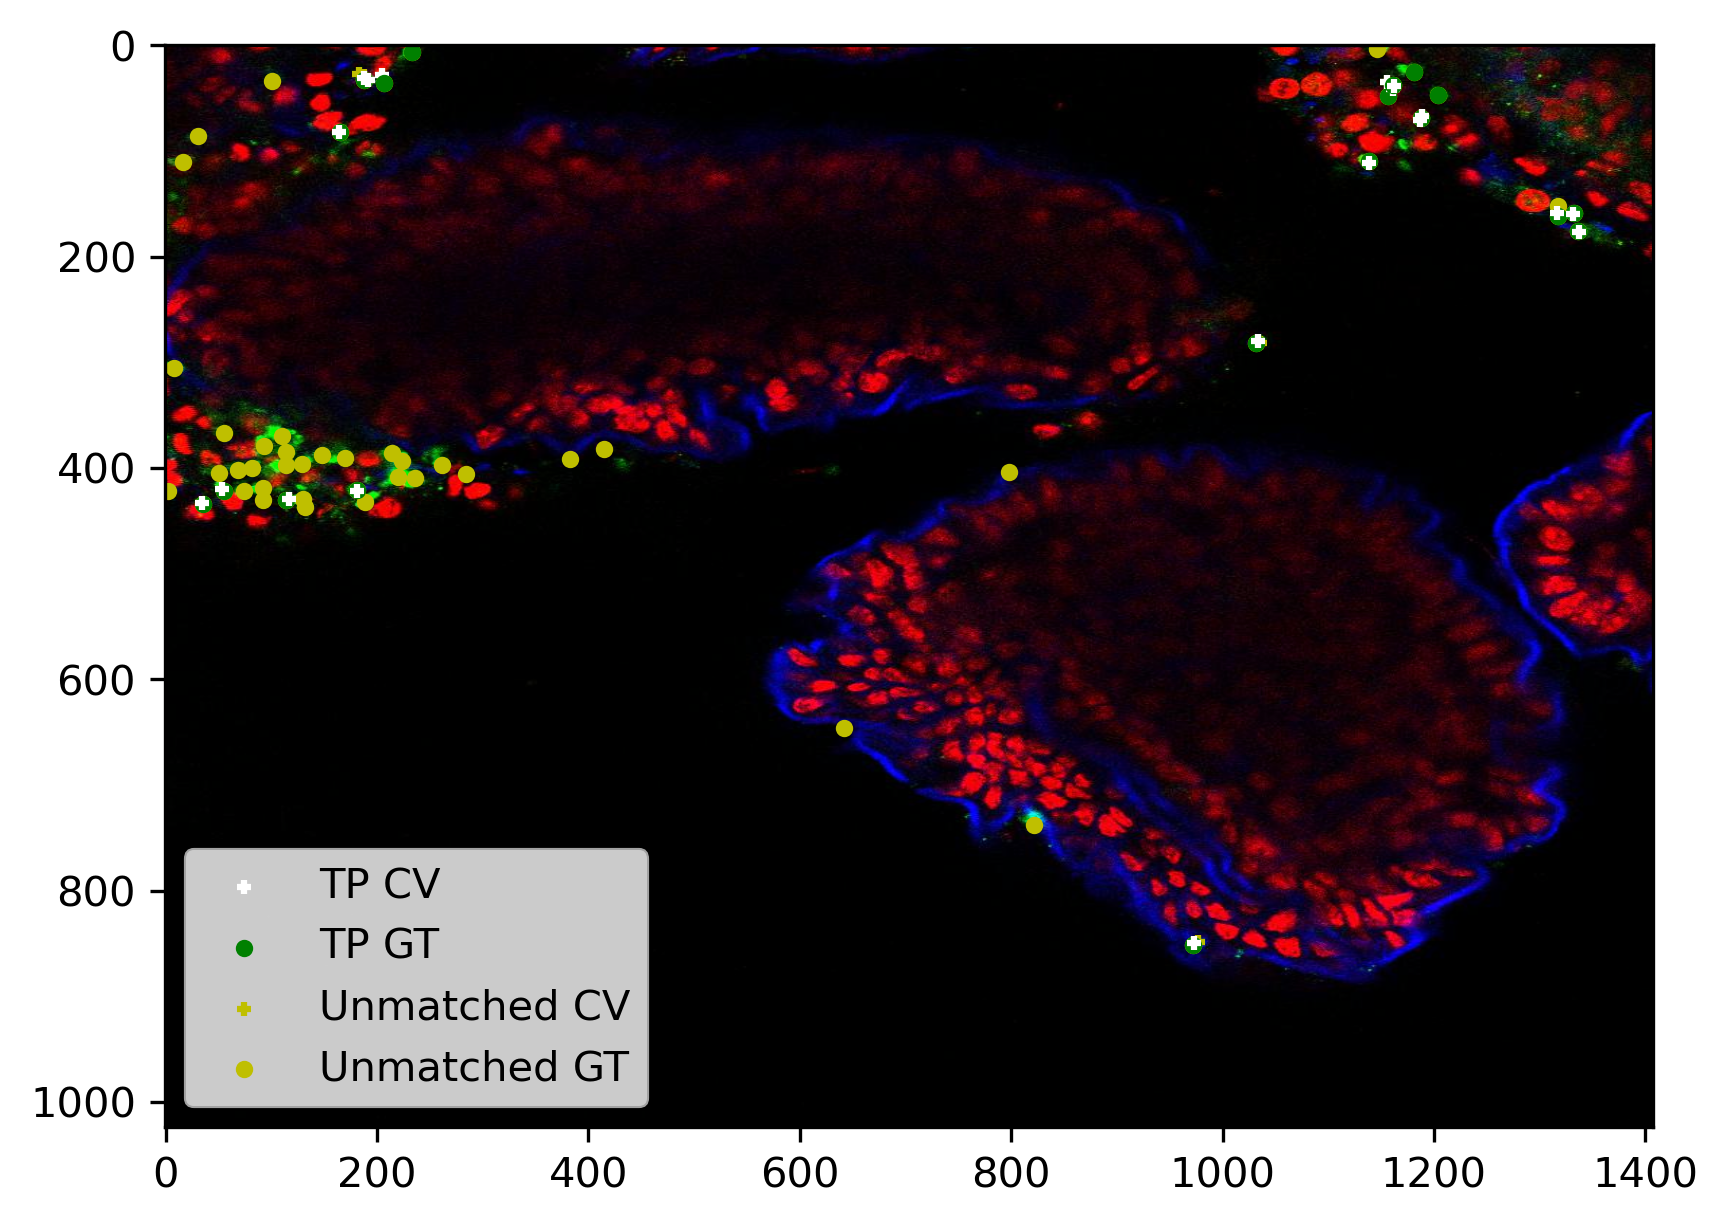

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


24
 TP 5 precision 0.9998000399920015 recall 0.22726239716376528


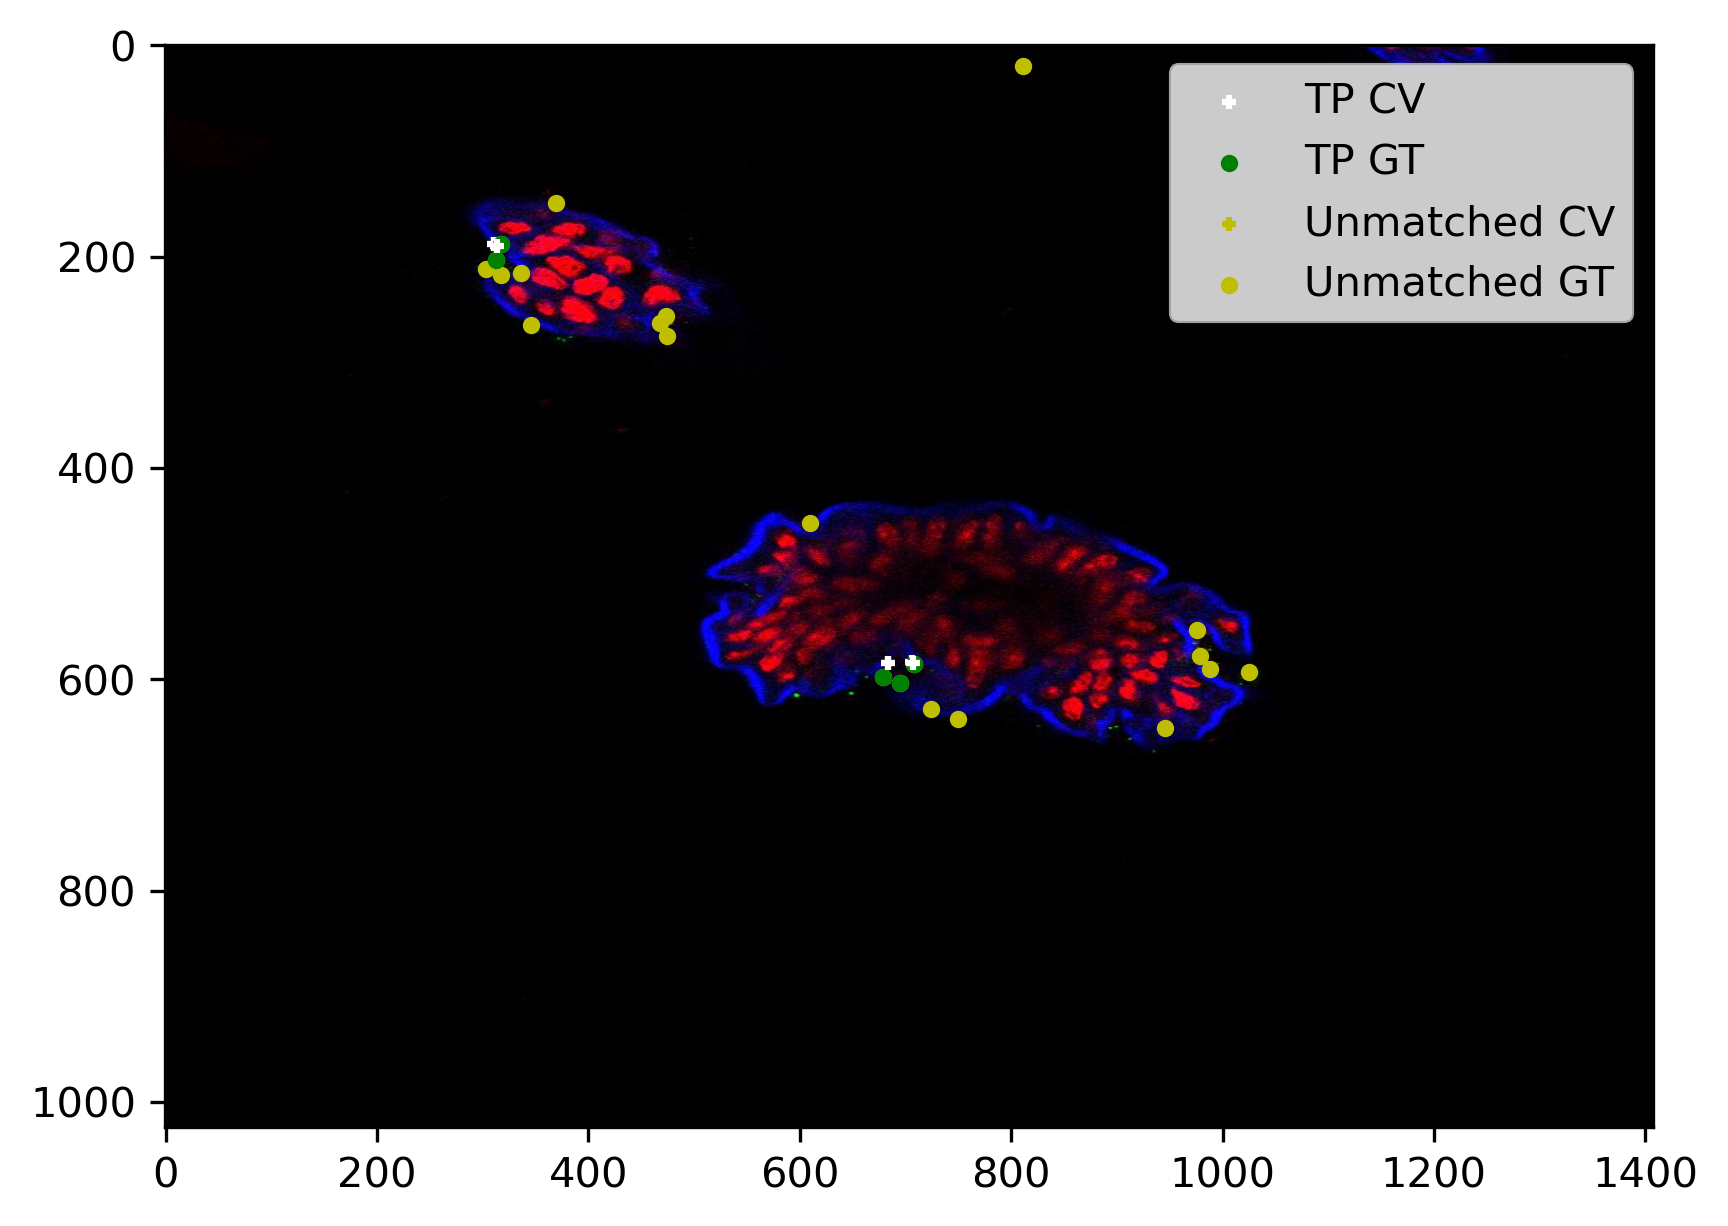

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


26
 TP 2 precision 0.9995002498750625 recall 0.06896313920209647


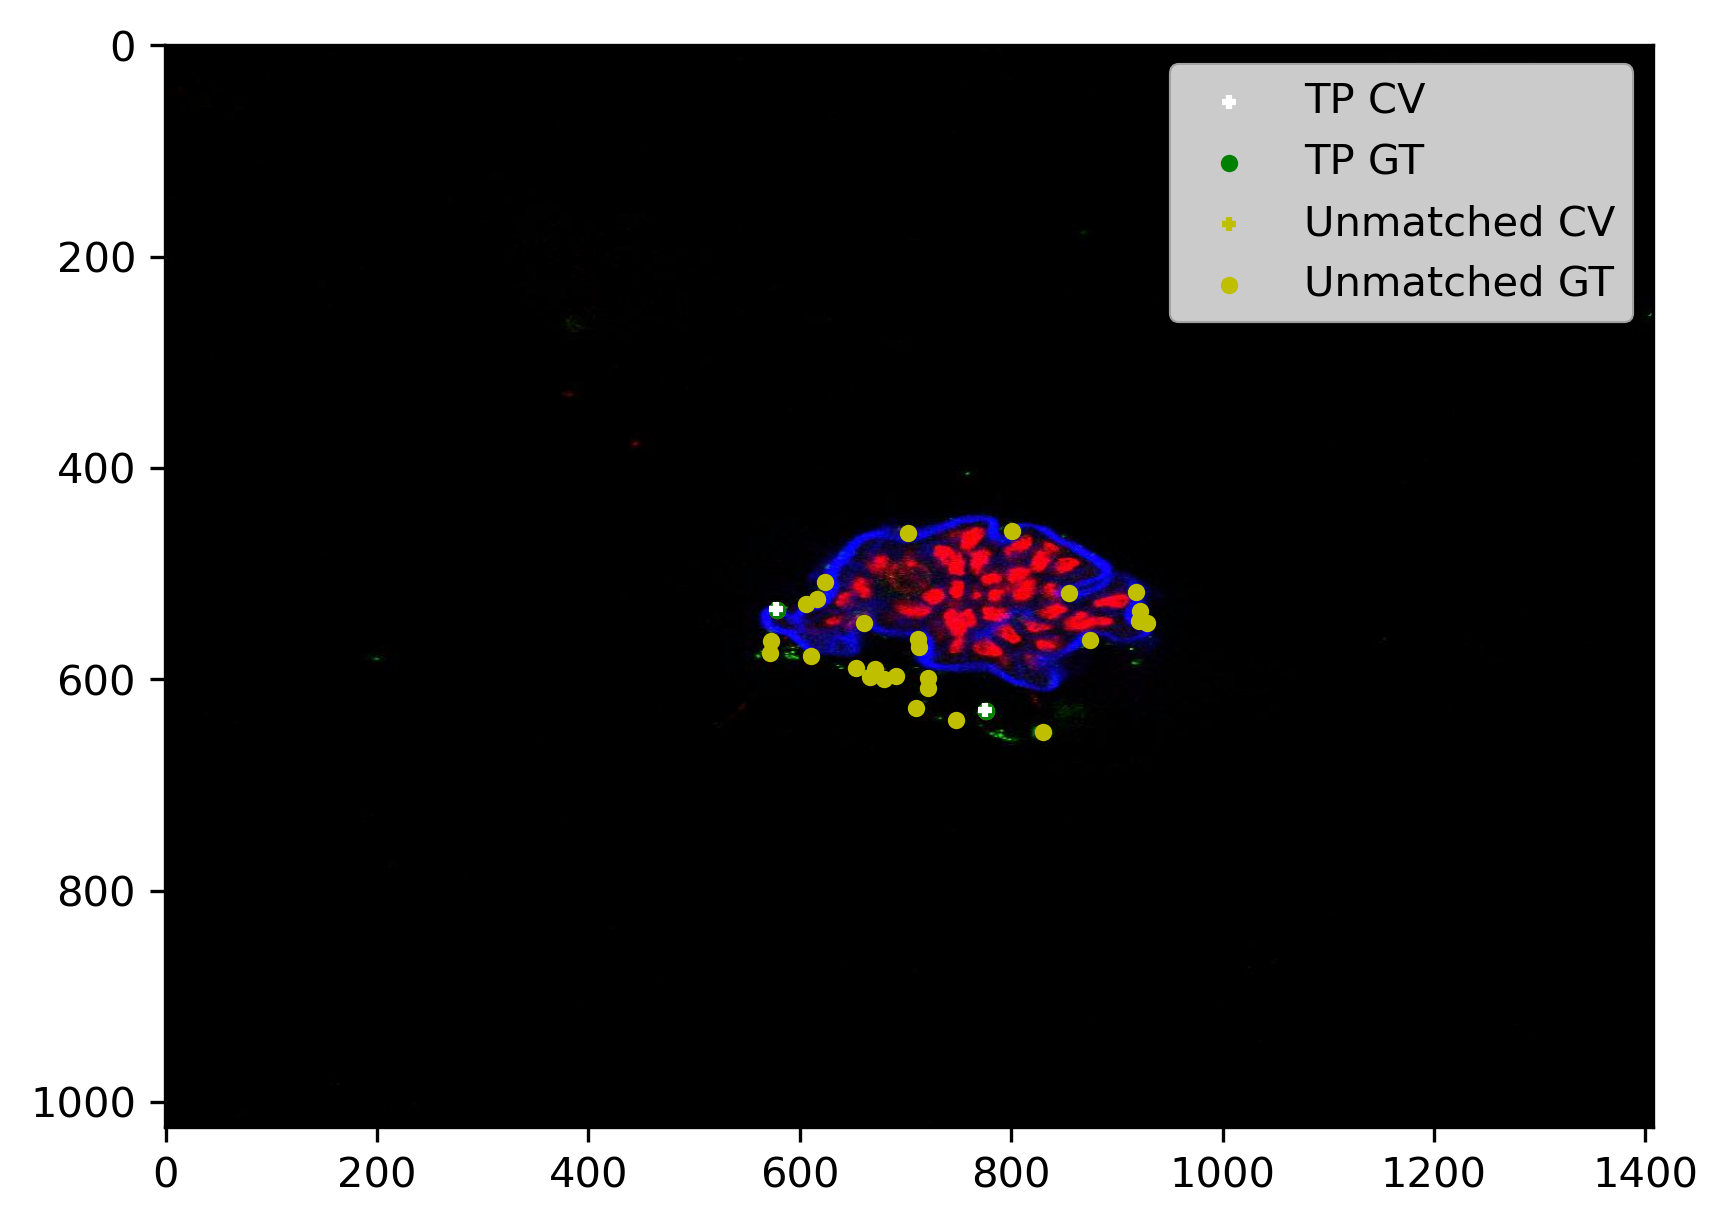

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


57
 TP 31 precision 0.8856889803148482 recall 0.4133278222957027


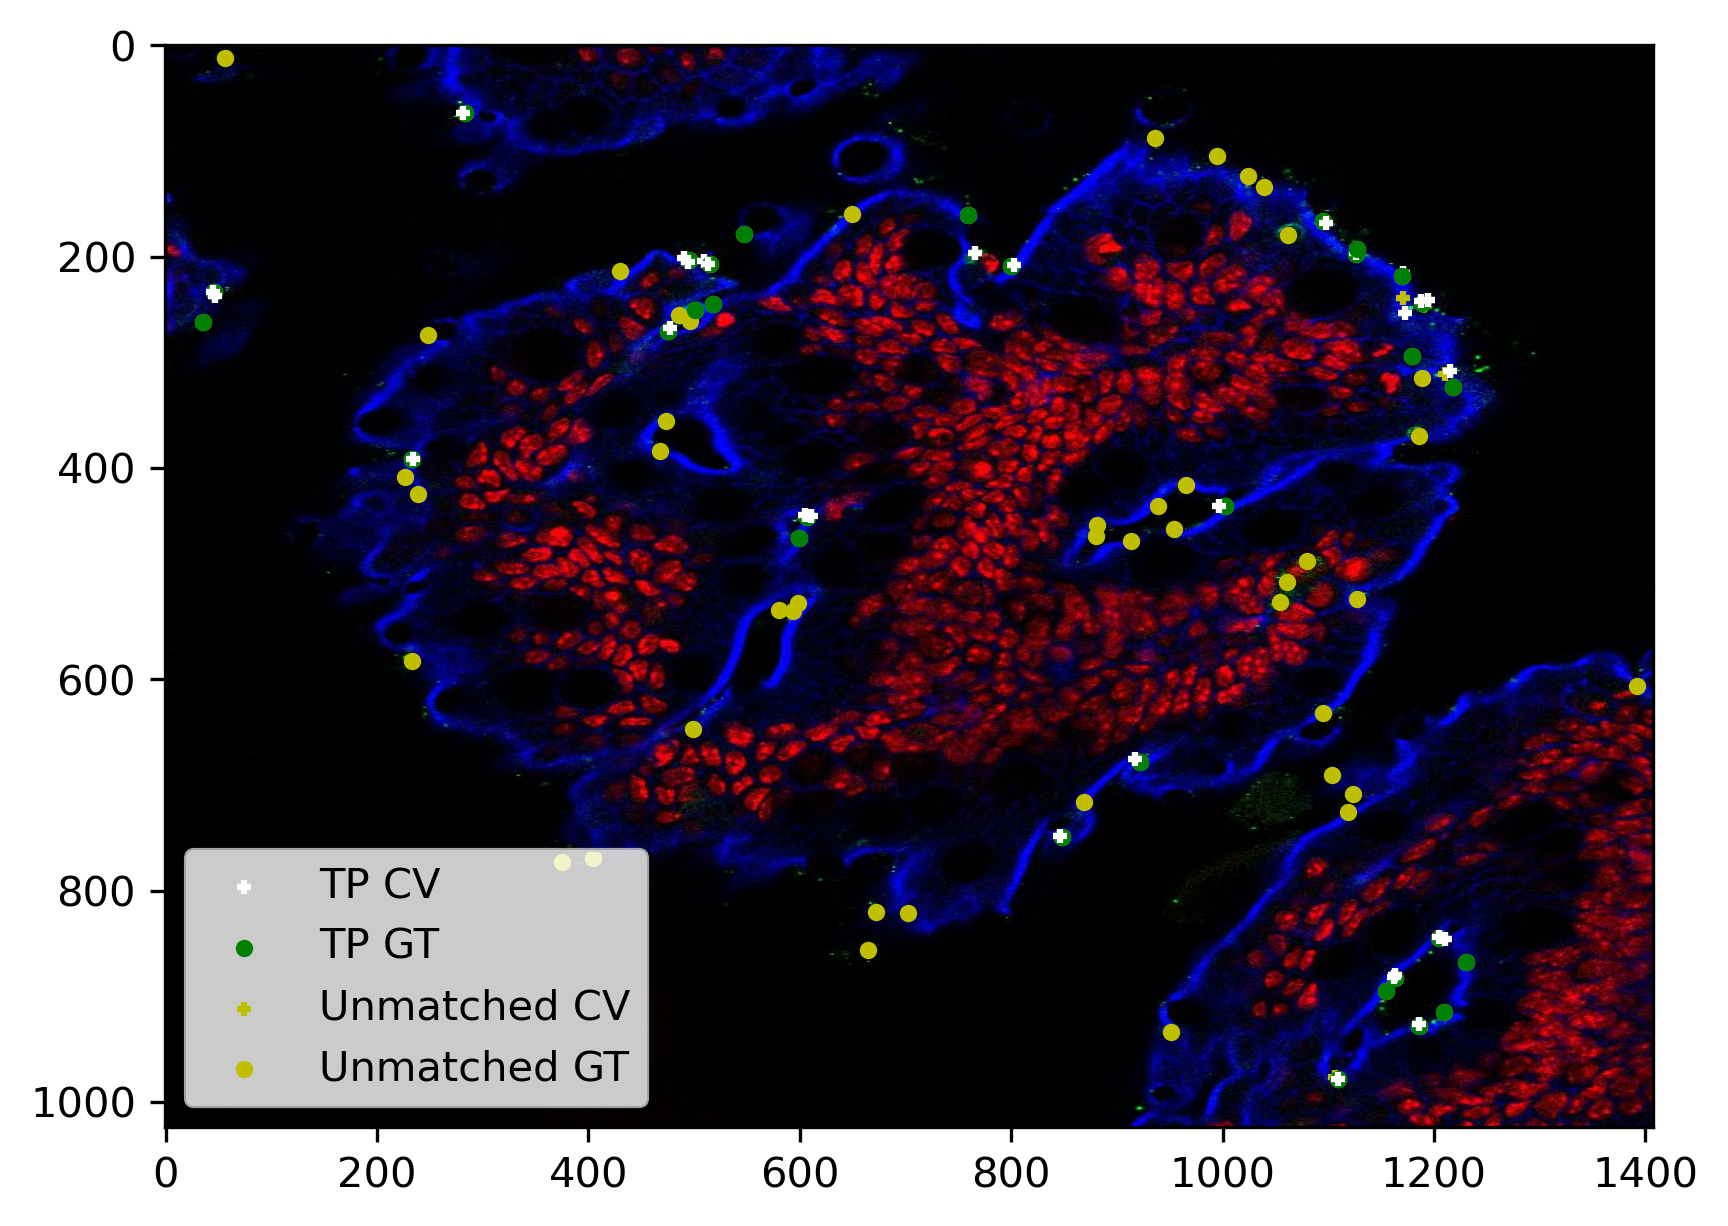

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


68
 TP 11 precision 0.7332844477034864 recall 0.24443901246638966


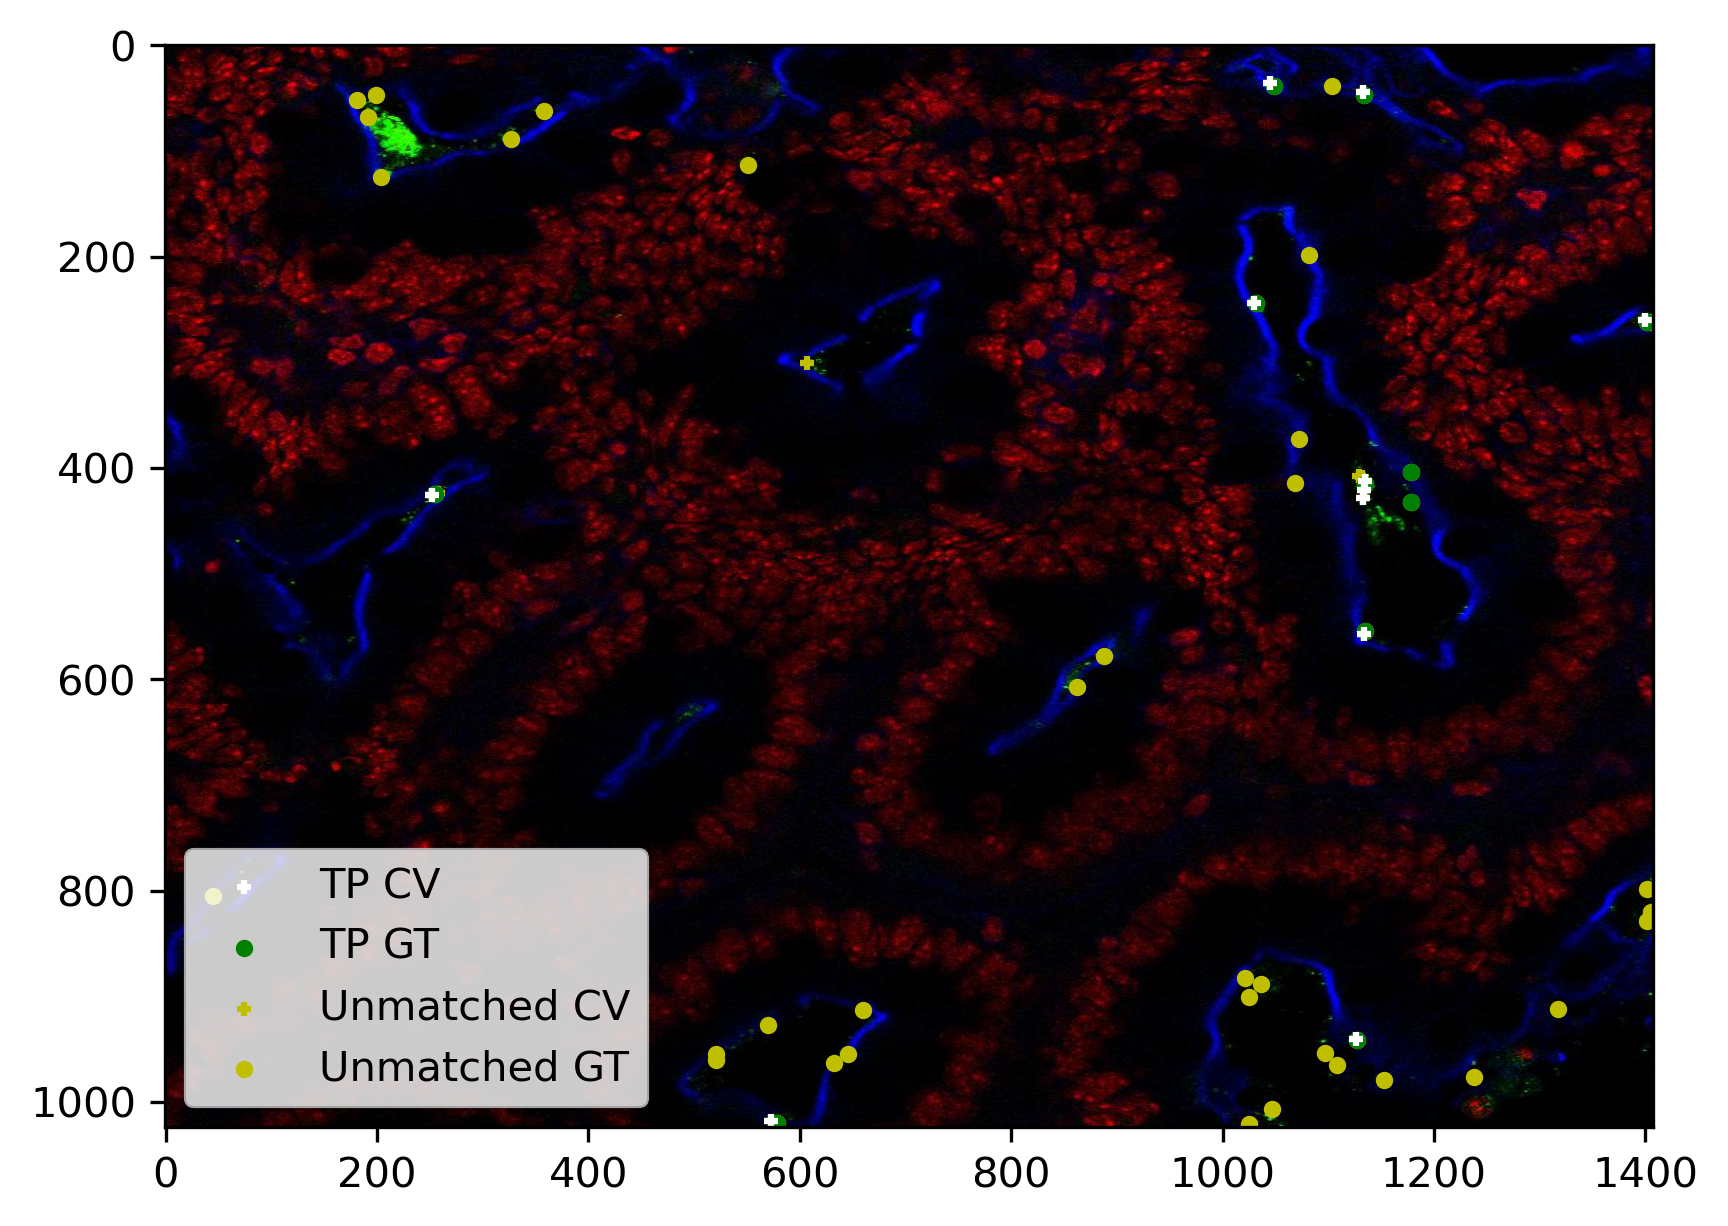

In [ ]:
total_tp=total_gt=total_pred=0
from matplotlib import rcParams as mpl_param
mpl_param["figure.dpi"] = 300
i=0 

for batch_images, batch_labels in data_loader_test:
    with torch.no_grad():
        outputs =     model(batch_images.to(device))

    for image,target,pred_logits, pred_points in zip(batch_images, batch_labels,outputs['pred_logits'],outputs['pred_points']):
        image=unorm(image)
        outputs_scores = torch.nn.functional.softmax(pred_logits, -1)[:, 1]
        points = pred_points[outputs_scores > 0.05].cpu().numpy()
        
        image_numpy = np.transpose(image.cpu(), (1, 2, 0))
        img_to_draw=image_numpy.numpy().copy() 
                
        y_true=target['point'].detach().cpu().numpy()
        
        cost_matrix,row_indices, col_indices=match_resutls(points, y_true)
        size=10
        tp=0

        yellow2=plt.scatter(y_true[:, 0], y_true[:, 1], s=size, marker='o', c='y', label='GT')
        yellow1=plt.scatter(points[:, 0], points[:, 1], s=size, marker='+', c='y', label='CV')
        
        for row, col in zip(row_indices, col_indices):
            if row < len(points) and col < len(y_true):
                pred_point = points[row]
                gt_point = y_true[col]
                if cost_matrix[row, col]<50:
                    circles=plt.scatter(gt_point[0], gt_point[1], s=size, marker='o', c='g', label='GT')
                    crosses=plt.scatter(pred_point[0], pred_point[1], s=size, marker='+', c='w', label='CV')
                    tp+=1
        
        total_tp+=tp
        total_gt+=len(y_true)
        total_pred+=len(points)
        # plt.figure(dpi=300)

        if i <5:
            print(total_tp)
            print(f' TP {tp} precision {tp/(len(points)+0.001) } recall {tp/(len(y_true)+0.001)}')            
            custom_legend_labels = ['TP CV', 'TP GT', 'Unmatched CV','Unmatched GT']
            custom_legend_handles = [crosses, circles,yellow1,yellow2]
            # Add a custom legend
            plt.legend(custom_legend_handles, custom_legend_labels)
            plt.imshow(img_to_draw)
            # plt.savefig(f'Evaluation/{i}.jpg',bbox_inches='tight')
            plt.show()
            plt.close()
        else:continue
        i+=1
        # break
    # break
print(f'total TP {total_tp} precision {total_tp/(total_pred+0.001) } recall {total_tp/(total_gt+0.001)}')

# Conclusion

The effect of transfer learning is evident. The performance improved after a few epochs. The loss function with the localization error is not necessary. 